In [71]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Read in both datasets, parsing dates
ny_air_quality = pd.read_csv(
    'new-york-air-quality.csv',
    parse_dates=['date']
)
df_aqi_raw = pd.read_csv(
    'daily_aqi_nyc.csv',
    parse_dates=['Date']
)
ny_air_quality['date'] = pd.to_datetime(ny_air_quality['date'], dayfirst=True)
ny_air_quality = ny_air_quality[
    (ny_air_quality['date'] >= '2014-01-01') &
    (ny_air_quality['date'] <= '2024-10-01')
].copy()

#Sort in-place by date
ny_air_quality.sort_values('date', inplace=True)


#Clean up any spaces in column names
ny_air_quality.columns = ny_air_quality.columns.str.strip()

#Ensure the dataframe is sorted by date
ny_air_quality = ny_air_quality.sort_values('date')

#Define which columns to convert
pollutants = ['pm25', 'o3', 'no2', 'co']

#Convert pollutant columns to numeric, coercing errors to NaN
for pol in pollutants:
    if pol in ny_air_quality.columns:
        ny_air_quality[pol] = pd.to_numeric(ny_air_quality[pol], errors='coerce').astype(float)

#Fill NaNs by linearly interpolating between the previous and next values; limit_direction='both' will also fill leading/trailing NaNs if possible
ny_air_quality[pollutants] = (ny_air_quality[pollutants].interpolate(method='linear', limit_direction='forward', axis=0))
ny_air_quality[pollutants] = ny_air_quality[pollutants].bfill().ffill()

FileNotFoundError: [Errno 2] No such file or directory: 'Slanzi_Assignment2\\assignment_package.zip'

BreakPoints

In [41]:

bp_pm25 = pd.DataFrame([
    {'C_low': 0.0,   'C_high': 9.0,    'I_low': 0,   'I_high': 50},
    {'C_low': 9.1,   'C_high': 35.4,   'I_low': 51,  'I_high': 100},
    {'C_low': 35.5,  'C_high': 55.4,   'I_low': 101, 'I_high': 150},
    {'C_low': 55.5,  'C_high': 125.4,  'I_low': 151, 'I_high': 200},
    {'C_low': 125.5, 'C_high': 225.4,  'I_low': 201, 'I_high': 300},
    {'C_low': 225.5, 'C_high': 400,  'I_low': 301, 'I_high': 500},
])

bp_o3 = pd.DataFrame([
    {'C_low': 0.00, 'C_high': 62.5, 'I_low':   0, 'I_high':  50},
    {'C_low': 62.5, 'C_high': 101.5, 'I_low':  51, 'I_high': 100},
    {'C_low': 101.5, 'C_high': 152.5, 'I_low': 101, 'I_high': 150},
    {'C_low': 152.5, 'C_high': 205, 'I_low': 151, 'I_high': 200},
    {'C_low': 205, 'C_high': 405, 'I_low': 201, 'I_high': 300},
    {'C_low': 405, 'C_high': 605, 'I_low': 301, 'I_high': 400}
])


bp_co = pd.DataFrame([
    {'C_low': 0.000,   'C_high': 4.4,   'I_low': 0,   'I_high': 50},
    {'C_low': 4.5,   'C_high': 9.4,   'I_low': 51,  'I_high': 100},
    {'C_low': 9.5,   'C_high': 12.4,  'I_low': 101, 'I_high': 150},
    {'C_low': 12.5,  'C_high': 15.4,  'I_low': 151, 'I_high': 200},
    {'C_low': 15.5,  'C_high': 30.4,  'I_low': 201, 'I_high': 300},
    {'C_low': 30.5,  'C_high': 40.4,  'I_low': 301, 'I_high': 400}
])

bp_no2 = pd.DataFrame([
    {'C_low': 0,     'C_high': 53,    'I_low': 0,   'I_high': 50},
    {'C_low': 54,    'C_high': 100,   'I_low': 51,  'I_high': 100},
    {'C_low': 101,   'C_high': 360,   'I_low': 101, 'I_high': 150},
    {'C_low': 361,   'C_high': 649,   'I_low': 151, 'I_high': 200},
    {'C_low': 650,   'C_high': 1249,  'I_low': 201, 'I_high': 300},
    {'C_low': 1250,  'C_high': 2049,  'I_low': 301, 'I_high': 400}
])
##Joint breakpoints
bps = {
    'pm25': bp_pm25,
    'o3': bp_o3,
    'no2': bp_no2,
    'co': bp_co
}

AQI computation

In [44]:
def compute_aqi(concentration, breakpoints):
    if pd.isna(concentration):
        return np.nan
    # find the matching breakpoint row
    match = breakpoints[
        (breakpoints['C_low'] <= concentration) &
        (breakpoints['C_high'] >= concentration)
    ]
    if match.empty:
        return np.nan
    row = match.iloc[0]
    Cl, Ch = row['C_low'], row['C_high']
    Il, Ih = row['I_low'], row['I_high']
    # return a float
    return ((Ih - Il) / (Ch - Cl)) * (concentration - Cl) + Il
for pol in ['pm25','o3','no2','co']:
    ny_air_quality[f"AQI_{pol}"] = ny_air_quality[pol]\
        .apply(lambda x: compute_aqi(x, bps[pol]))
aqi_cols = [f"AQI_{pol}" for pol in pollutants]
for col in aqi_cols:
    prev = ny_air_quality[col].ffill()
    nxt  = ny_air_quality[col].bfill()
    fill_vals = np.where(
        prev.isna(), nxt,
        np.where(nxt.isna(), prev, (prev + nxt)/2)
    )
    ny_air_quality[col] = np.where(
        ny_air_quality[col].isna(),
        fill_vals,
        ny_air_quality[col]
    )

Analysis of the AQI values for each pollutant between 01-01-2014 up to 10-01-2024

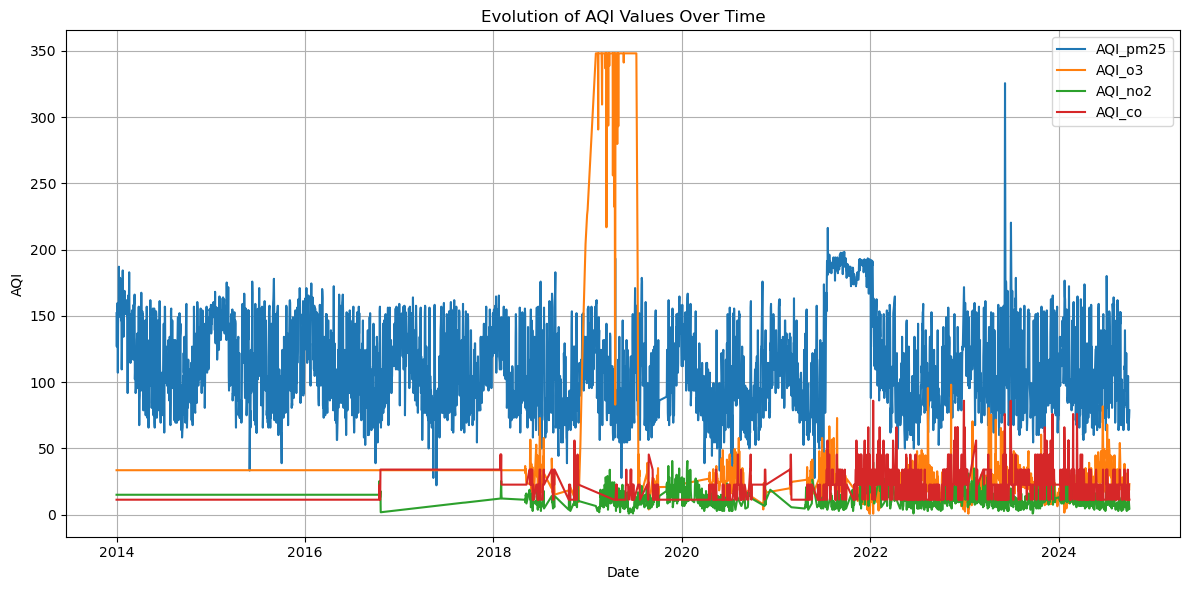

In [46]:

aqi_cols = ['AQI_pm25', 'AQI_o3', 'AQI_no2', 'AQI_co']
data = ny_air_quality[['date'] + aqi_cols].copy()

# Ordering dates
data['date'] = pd.to_datetime(data['date'])

# Plot
plt.figure(figsize=(12, 6))
for col in aqi_cols:
    plt.plot(data['date'], data[col], label=col)

plt.title('Evolution of AQI Values Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
# Select only the pollutant columns
pollutants = ['pm25', 'o3', 'no2', 'co']

# Correct column names
aqi_cols = [f"AQI_{pol}" for pol in pollutants]

# Correct max AQI and pollutant responsible
ny_air_quality['max_aqi'] = ny_air_quality[aqi_cols].max(axis=1)
ny_air_quality['main_pollutant'] = ny_air_quality[aqi_cols].idxmax(axis=1).str.replace('AQI_', '')


result = ny_air_quality[['date', 'max_aqi', 'main_pollutant']]
display(result)

date     max_aqi main_pollutant
3922 2014-01-01  152.051502           pm25
3923 2014-01-02  126.854271           pm25
3924 2014-01-03  149.015075           pm25
3925 2014-01-04  151.350501           pm25
3926 2014-01-05  159.762518           pm25
...         ...         ...            ...
225  2024-09-27   76.897338           pm25
226  2024-09-28   63.855513           pm25
227  2024-09-29   71.307985           pm25
228  2024-09-30   73.171103           pm25
47   2024-10-01   78.760456           pm25

[3888 rows x 3 columns]

In [48]:
# Create a new dataframe
result_with_level = ny_air_quality[['date', 'max_aqi', 'main_pollutant']].copy()

#Define AQI level categorization function
def aqi_level(aqi):
    if aqi <= 50:
        return 'good'
    elif aqi <= 100:
        return 'moderate'
    elif aqi <= 150:
        return 'unhealthy for sensitive groups'
    elif aqi <= 200:
        return 'unhealthy'
    elif aqi <= 300:
        return 'very unhealthy'
    else:
        return 'hazardous'

result_with_level.loc[:, 'level'] = result_with_level['max_aqi'].apply(aqi_level)

display(result_with_level)

date     max_aqi main_pollutant                           level
3922 2014-01-01  152.051502           pm25                       unhealthy
3923 2014-01-02  126.854271           pm25  unhealthy for sensitive groups
3924 2014-01-03  149.015075           pm25  unhealthy for sensitive groups
3925 2014-01-04  151.350501           pm25                       unhealthy
3926 2014-01-05  159.762518           pm25                       unhealthy
...         ...         ...            ...                             ...
225  2024-09-27   76.897338           pm25                        moderate
226  2024-09-28   63.855513           pm25                        moderate
227  2024-09-29   71.307985           pm25                        moderate
228  2024-09-30   73.171103           pm25                        moderate
47   2024-10-01   78.760456           pm25                        moderate

[3888 rows x 4 columns]

POINT 2

In [50]:

df_aqi_raw['Date'] = pd.to_datetime(df_aqi_raw['Date'])
df_official = (
    df_aqi_raw
      .loc[
         (df_aqi_raw['Date'] >= '2014-01-01') &
         (df_aqi_raw['Date'] <= '2024-10-01'),
      ]
      .rename(columns={'Date':'date', 'AQI':'aqi_official'})
      [['date','aqi_official']]
      .sort_values('date')
      .reset_index(drop=True)
)

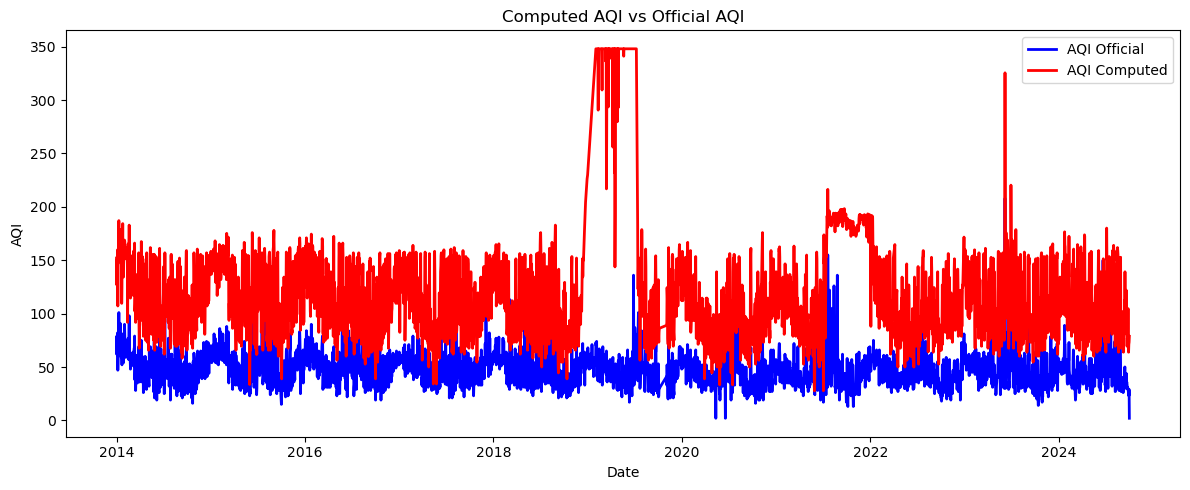

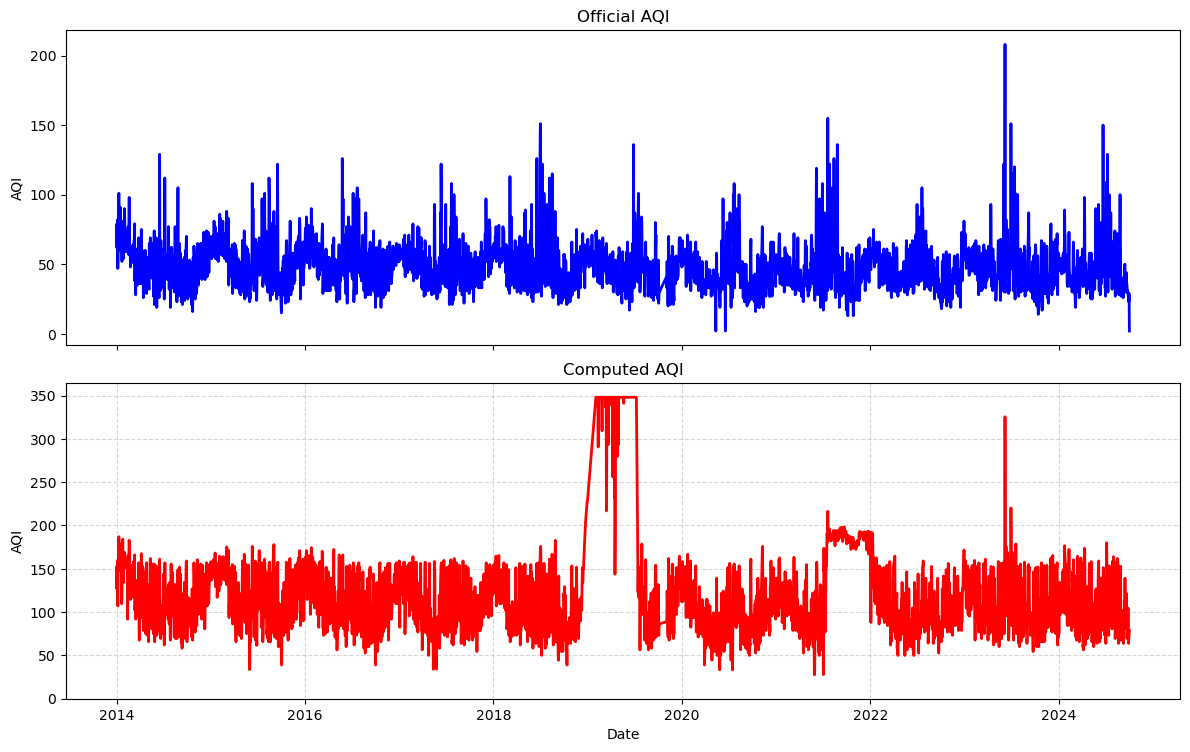

In [51]:
import matplotlib.pyplot as plt

# Rebuild 'result' and merged df_plot
comp = result.rename(columns={'max_aqi':'aqi_computed'})
df_plot = comp.merge(df_official, on='date', how='inner').sort_values('date')

#Overlay with distinct colors
official_color = 'blue'
computed_color = 'red'

plt.figure(figsize=(12,5))
plt.plot(df_plot['date'], df_plot['aqi_official'],
         label='AQI Official', color=official_color, linewidth=2)
plt.plot(df_plot['date'], df_plot['aqi_computed'],
            label='AQI Computed', color=computed_color, linewidth=2)
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Computed AQI vs Official AQI')
plt.legend()
plt.tight_layout()
plt.show()

#  Separate plots
fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)

# Official AQI alone
axes[0].plot(df_plot['date'], df_plot['aqi_official'],
             color=official_color, linewidth=2)
axes[0].set_title('Official AQI')
axes[0].set_ylabel('AQI')

# Computed AQI alone
axes[1].plot(df_plot['date'], df_plot['aqi_computed'],
             color=computed_color, linewidth=2)
axes[1].set_title('Computed AQI')
axes[1].set_ylabel('AQI')
axes[1].set_xlabel('Date')

# Tighter vertical margin
y_min = df_plot['aqi_computed'].min()
y_max = df_plot['aqi_computed'].max()
margin = (y_max - y_min) * 0.05  # 5% margin

y_lower = max(0, y_min - margin)
y_upper = y_max + margin

axes[1].set_ylim(0, y_upper)

axes[1].grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()


In [52]:
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot['month'] = df_plot['date'].dt.month

#Computation the average by month
seasonal = (
    df_plot
    .groupby('month')[['aqi_official', 'aqi_computed']]
    .mean()
    .reindex(range(1,13))   # ensure months 1–12 in order
)



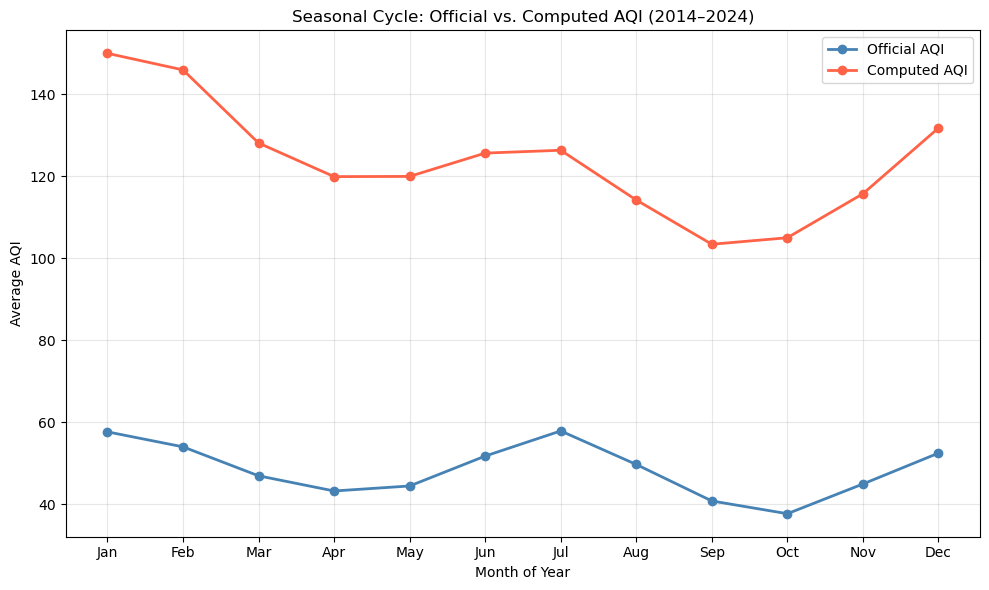

In [53]:
# Plot the seasonal cycle
plt.figure(figsize=(10,6))
plt.plot(seasonal.index, seasonal['aqi_official'],
         marker='o', linestyle='-', linewidth=2,
         label='Official AQI', color='steelblue')
plt.plot(seasonal.index, seasonal['aqi_computed'],
         marker='o', linestyle='-', linewidth=2,
         label='Computed AQI', color='tomato')

plt.xticks(range(1,13), 
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel('Month of Year')
plt.ylabel('Average AQI')
plt.title('Seasonal Cycle: Official vs. Computed AQI (2014–2024)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [54]:
df_official.describe()

date  aqi_official
count                 3927   3927.000000
mean   2019-05-18 00:00:00     48.458111
min    2014-01-01 00:00:00      2.000000
25%    2016-09-08 12:00:00     37.000000
50%    2019-05-18 00:00:00     48.000000
75%    2022-01-23 12:00:00     57.000000
max    2024-10-01 00:00:00    208.000000
std                    NaN     16.677111

In [55]:
result.describe()

date      max_aqi
count                           3888  3888.000000
mean   2019-05-19 00:08:08.888889088   123.958704
min              2014-01-01 00:00:00    27.777778
25%              2016-09-02 18:00:00    86.212928
50%              2019-05-07 12:00:00   112.080402
75%              2022-02-02 06:00:00   146.552764
max              2024-10-01 00:00:00   348.025000
std                              NaN    58.868311

2. Check the differences between the AQI calculated from the first dataset with the
one in the second dataset.

a. Is there any difference?

b. For which dates you note a difference?

c. Are there any missing data?


a) As observed in Graph 1, which compares the computed AQI with the official AQI, both series exhibit a seasonality trend which is similar, and their correlation(computed below) is 0.3554.
This differences are primarily driven by the different dataset available.
The AQI values of the official report lead to ranges of pollutants which are most of the times below the ranges of the computed AQI.

It appears that both series reflect the same city’s air quality, but the computed AQI may represents a much more polluted part of the city.
The two tables presented above compare the AQI values from the respective dataframes. The computed AQI shows both a higher mean and greater volatility relative to the official values.

Notably, in 2019, there is a peak in the computed AQI, attributed to several dates with ozone concentrations reaching the maximum value of 500ppm.

b)The two DataFrames have no values in common; even their correlation(computed below) is equal to 0.3554, which is low.
If we observe the seasonality plot although it's possible to notice a similar seasonality trend.

c) The computed AQI dataset contains 39 missing dates within the period from January 1, 2014, to January 10, 2024. These dates are not included in the ny_air_quality file and therefore are absent from the analysis.
For the missing relevations of concentration of pollutant in the air I used the linear interpolation, and for the missing values at the beginning or end of the Dataframe I simply copied the values observed in the closer relevation available to fill the Nan values.


In [58]:
# Merge both dataframes on 'date'
merged = pd.merge(df_official, result, on='date', how='inner')
merged = merged.dropna(subset=['aqi_official', 'max_aqi'])
correlation = merged['aqi_official'].corr(merged['max_aqi'])
print(f"Correlation between the official AQI and computed AQI: {correlation:.4f}")


Correlation between the official AQI and computed AQI: 0.3554


3a)Bonus: plots AQI data against time (at daily level and monthly / yearly
aggregated).
a. Which trend can you observe?

3a)From thee seasonality graph it's oobservable that both the official and computed AQI curves follow the same winter‐peak and spring and autumn‐dip patterns, confirming a similar seasonal cycle.
However, the computed values are consistently above the official ones, suggesting they may have been retrieved from a more polluted area of New York City.